In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df_curve = pd.read_csv('./mic_sling_output/principal_curve.csv')
df_pca = pd.read_csv('./mic_diff_pca.csv')
df_time = pd.read_csv('./mic_sling_output/pseudotime.csv')
df_meta = pd.read_csv('./data/mic_diff_meta.csv')

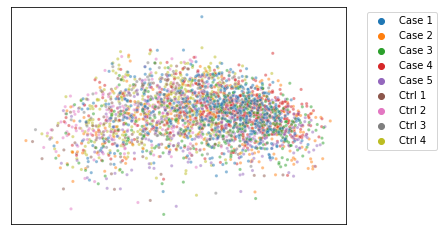

In [6]:
subject_id2showname = {'NPBB052':'Ctrl 1',
 'NPBB098':'Ctrl 2',
 'NPBB105':'Ctrl 3',
 'NPBB113':'Ctrl 4',
 'NPBB131':'Case 1',
 'NPBB135':'Case 2',
 'NPBB137':'Case 3',
 'NPBB138':'Case 4',
 'NPBB139':'Case 5',}
df_meta['showname'] = [subject_id2showname[s] for s in df_meta.subject_id]
df_meta.showname = df_meta.showname.astype('category')

sns.scatterplot(x=-df_pca.pc0, y = df_pca.pc1, hue = df_meta.showname, s = 10, alpha = 0.5)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()

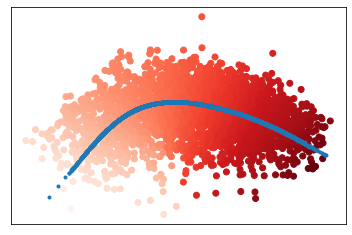

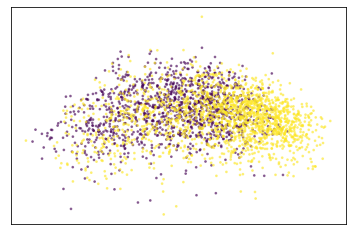

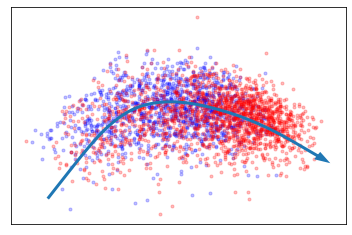

In [3]:
#plt.plot(df_pca.pc0, df_pca.pc1, '.')
plt.scatter(-df_pca.pc0, df_pca.pc1, c = df_time.pt, cmap = 'Reds')
plt.plot(-df_curve.pc0, df_curve.pc1, '.')
plt.xticks([])
plt.yticks([])
plt.show()

plt.show()
plt.scatter(-df_pca.pc0, df_pca.pc1, c = df_meta.is_covid, s = 3, alpha = 0.5)
plt.xticks([])
plt.yticks([])
plt.show()

from scipy.interpolate import interp1d

ind = np.argsort(df_curve.pc0)
x = df_curve.pc0[ind]
y = df_curve.pc1[ind]
f = interp1d(x, y)

xx = np.linspace(df_curve.pc0.min(), df_curve.pc0.max(), num=11, endpoint=True)
yy = f(xx)



#plt.scatter(-df_pca.pc0, df_pca.pc1, c = df_meta.is_covid, s = 3, alpha = 0.5)
plt.plot(-df_pca.pc0[df_meta.is_covid == 0], 
            df_pca.pc1[df_meta.is_covid == 0], 'b.', alpha = 0.24, zorder=1, label = 'ctrl')
plt.plot(-df_pca.pc0[df_meta.is_covid == 1], 
            df_pca.pc1[df_meta.is_covid == 1], 'r.', alpha = 0.25, zorder=2, label = 'COVID-19')


plt.plot(-x, y, linewidth = 3, zorder=3)
#for i in range(10):
if True:
    i = 0
    x, y = xx[i], yy[i]
    dx, dy = xx[i] - xx[i+1], yy[i] - yy[i+1]
    plt.arrow(-x, y, -0.5 * dx, 0.5 * dy, width = 0.2,zorder=3, shape='full', lw=0, 
              length_includes_head=True)
    
plt.xticks([])
plt.yticks([])
plt.savefig('../../figs/traj_scatter.pdf')
plt.savefig("../../figs/png/traj_scatter.png", dpi = 600, bbox_inches='tight')

plt.show()

In [4]:
vec = df_time.values
vec = vec / vec.max()

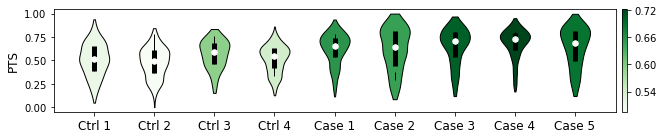

In [28]:
import matplotlib as mpl
from matplotlib import ticker
cmap = mpl.cm.Greens

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
    
def plot_violin(data, colors, cmap, ax):
    parts = ax.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False)

    for pc, (c, _) in zip(parts['bodies'], colors):
        pc.set_facecolor(c)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    
    quartile1, medians, quartile3 = [], [], []
    for v in data:
        q1, m, q3 = np.percentile(v, [25, 50, 75])
        quartile1 += [q1]
        medians += [m] 
        quartile3 += [q3]
        
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
    #ax.pcolor([c[1] for c in colors], cmap=cmap)
    norm = mpl.colors.Normalize(vmin=min([c[1] for c in colors]), 
                                vmax=max([c[1] for c in colors]))
    
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm , cmap=cmap), pad = 0.01, ax=ax)
    
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator
    cb.update_ticks()
    
    return ax



import matplotlib as mpl
cmap = mpl.cm.Greens

id2subject = sorted(set(df_meta.subject_id))

#fig, axes = plt.subplots(4, 1, figsize = (10, 6), sharex=True)
fig, ax = plt.subplots(1, 1, figsize = (10, 2))

data = [np.squeeze(vec[df_meta.subject_id == s]).copy() for s in id2subject]
med = np.array([np.median(v) for v in data])
med_norm = (med - med.min()) / (med.max() - med.min())
colors = [(cmap(mn), m) for m, mn in zip(med, med_norm)]
    
#colors = ['#D43F3A'] * 9
ax = plot_violin(data, colors, cmap, ax)
#ax.set_title(v.replace('_', ' '))

plt.tight_layout()
#plt.xticks([i+1 for i in range(9)], id2subject, fontsize = 12)
id2label = ['Ctrl %d' % i for i in range(1, 5)] + ['Case %d' % i for i in range(1, 6)]
plt.xticks([i+1 for i in range(9)], id2label, fontsize = 12)

#fig.text(-0.02, 0.5, 'PTS', va='center', rotation='vertical', fontsize = 12)
plt.ylabel('PTS', fontsize = 12)
plt.savefig('../../figs/traj_PTS_violin.pdf', bbox_inches='tight')
plt.savefig("../../figs/png/traj_PTS_violin.png", dpi = 600, bbox_inches='tight')
plt.show()


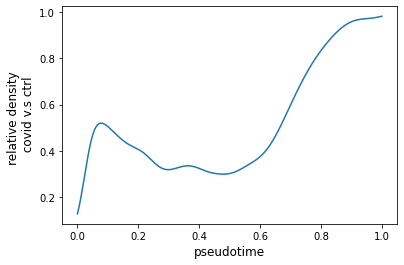

Text(0, 0.5, 'density')

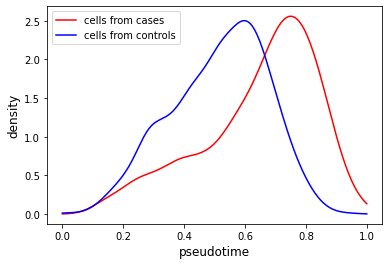

In [6]:
from scipy.stats import gaussian_kde
t0 = df_time.pt.values
t0 = t0 / max(t0)
p0 = gaussian_kde(t0[df_meta.is_covid == 0])
p1 = gaussian_kde(t0[df_meta.is_covid == 1])
xx = np.linspace(-0, 1, 200)
v1 = p1(xx)
v0 = p0(xx)
plt.plot(xx, v1 / (v0 + v1))
plt.xlabel('pseudotime', fontsize = 12)
plt.ylabel('relative density \n covid v.s ctrl', fontsize = 12)
plt.show()
plt.plot(xx, v1, 'r', label = 'cells from cases')
plt.plot(xx, v0, 'b', label = 'cells from controls')
plt.legend()
plt.xlabel('pseudotime', fontsize = 12)
plt.ylabel('density', fontsize = 12)

In [5]:
df = pd.read_csv('./mic_sling_output/yhat_scaled.csv', index_col = 0)
df_label = pd.read_csv('./mic_sling_output/clusterLabel.csv', index_col = 0)
df_label = df_label.loc[df.index]

In [6]:
df_label.shape, df.shape

((661, 1), (661, 20))

In [10]:
from collections import Counter
tmp = Counter(df_label.cluster)
[(c, tmp[c]) for c in sorted(tmp.keys())]

[(-2, 15),
 (0, 44),
 (1, 24),
 (2, 16),
 (3, 15),
 (4, 14),
 (5, 14),
 (6, 13),
 (7, 18),
 (8, 13),
 (9, 13),
 (10, 12),
 (11, 11),
 (12, 11),
 (13, 16),
 (14, 10),
 (15, 36),
 (16, 7),
 (17, 6),
 (18, 6),
 (19, 6),
 (20, 6),
 (21, 15),
 (22, 320)]

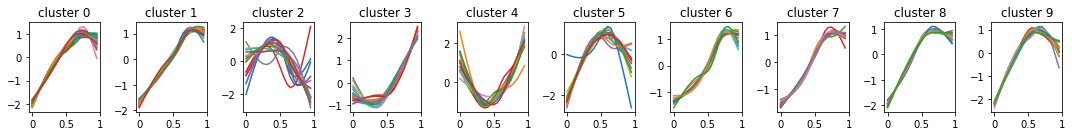

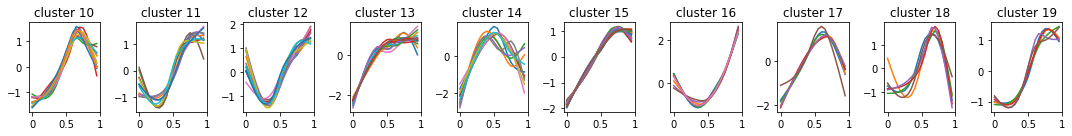

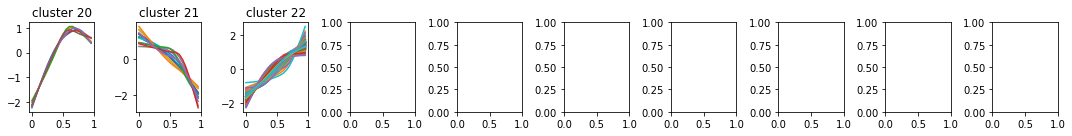

In [9]:
for t in range(3):
    fig, axes = plt.subplots(1, 10, figsize = (15, 2))
    for i in range(10):
        ind = (t * 10 + i)
        plt.sca(axes[i])
        if any(df_label.cluster == ind):
            plt.plot(df.values[df_label.cluster == ind].T)
            plt.title('cluster %d' % ind)
            plt.xticks([0, 10, 20], [0, 0.5, 1])
    plt.tight_layout()
    plt.show()

In [10]:
import numpy as np

mean_curves = []
for i in range(max(df_label.cluster) + 1):
    if sum(df_label.cluster == i) == 0:
        print(i)
    mean_curves.append(df.values[df_label.cluster == i, ].mean(axis = 0))
mean_curves = np.vstack(mean_curves)


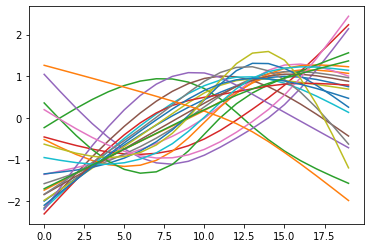

In [11]:
plt.plot(mean_curves.T)
plt.show()

In [12]:
import numpy as np
from sklearn.manifold import SpectralEmbedding
import seaborn as sns
from sklearn.cluster import KMeans

In [13]:
mat = mean_curves

In [14]:
from dtw import dtw

nc = mat.shape[0]
distmap = np.zeros((nc, nc))

manhattan_distance = lambda x, y: np.abs(x - y) ** 2

for i in range(nc):
    for j in range(i+1, nc):
        x = mat[i]
        y = mat[j]
        d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=manhattan_distance)
        distmap[i, j] = d
        distmap[j, i] = d

In [15]:
med_dist = np.median(distmap.ravel())

In [16]:
ind_nbr = np.argsort(distmap)
nbr_graph = np.zeros_like(distmap)
for i in range(distmap.shape[0]):
    nbr_graph[i, ind_nbr[:6]] = 1 ## include self
#nbr_graph = np.maximum(nbr_graph, nbr_graph)

In [17]:
affinity = np.exp(- distmap / ( med_dist))# * nbr_graph
affinity = (affinity + affinity.T) / 2.

In [18]:
clf2 = SpectralEmbedding(n_components=2, affinity='precomputed', n_jobs=10)
Xre = clf2.fit_transform(affinity)
#clf2 = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_jobs=10)
#Xre = clf2.fit_transform(mat)

In [19]:
clf = KMeans(n_clusters=6).fit(Xre)
clf.cluster_centers_
cluster_sort = np.argsort(clf.cluster_centers_[:, 0])

Counter({0: 12, 5: 4, 3: 3, 4: 2, 2: 1, 1: 1})


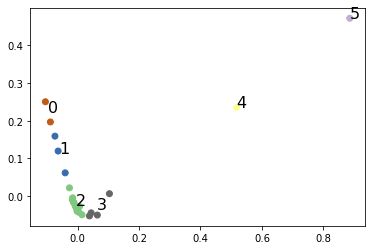

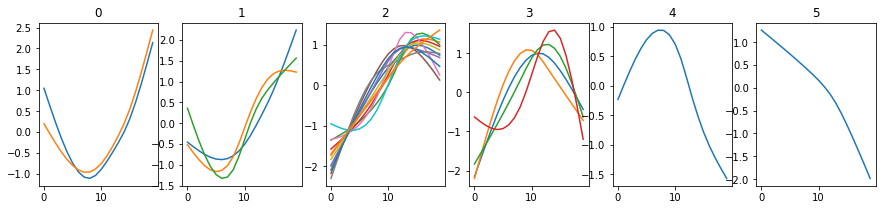

In [20]:
from collections import Counter
from sklearn.cluster import KMeans


print(Counter(clf.labels_))
plt.scatter(Xre[:, 0], Xre[:, 1], c = clf.labels_, cmap = 'Accent')

for i, ic in enumerate(cluster_sort):
    x = Xre[clf.labels_ == ic, 0].mean()
    y = Xre[clf.labels_ == ic, 1].mean()
    plt.text(x, y, str(i), fontsize = 16)
    
fig, axes = plt.subplots(1, 6, figsize = (15, 3))
for i, ind in enumerate(cluster_sort):
    plt.sca(axes[i])
    if any(clf.labels_ == ind):
        plt.plot(mat[clf.labels_ == ind].T)
        plt.title(i)
plt.show()

In [21]:
res = []
for ic, (cn, cl) in enumerate([('increasing', [0, 1, 2]), 
                         ('early transient', [4]), 
                         ('late transient', [3]), 
                         ('decreasing', [5])
                        ]):
    for i in cl:
        ind = []
        for j in np.where(clf.labels_ == cluster_sort[i])[0]:
            ind += list(np.where(df_label == j)[0])
        for j in ind:
            res += [(df_label.index[j], ic, cn)]

In [22]:
df_res = pd.DataFrame(res, columns = ['gene', 'cluster', 'cluster_name'])
df_res.to_csv('mic_sling_output/cluster2gene.csv', index = False)

In [23]:
df_res.shape

(646, 3)

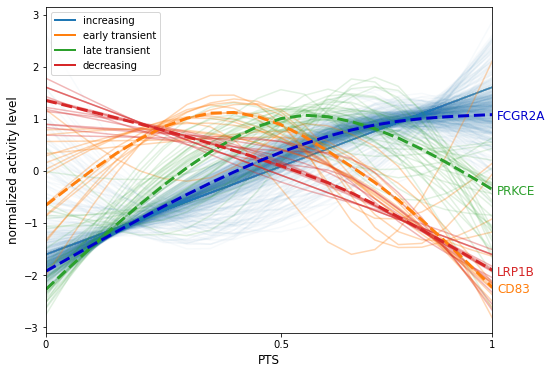

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.lines import Line2D

# Generate data...
fig = plt.subplots(figsize = (8, 6))
cmap = mpl.cm.tab10
id2label = ['increasing', 'early transient', 'late transient', 'decreasing']

for i, (k, item) in enumerate(df_res.groupby('cluster')):
    plt.plot(df.loc[item.gene].values.T, 
             color = cmap(i / 10), alpha = max(5 / item.shape[0], 0.03))
    
#plt.text(.1, df.loc['CD83'].values[1], 'CD83', color = cmap(2 / 10), fontsize = 12)

mk = 'CD83'
col = cmap(1 / 10)
plt.text(19.2, df.loc[mk].values[19] - 0.1, mk, color = col, fontsize = 12)
plt.plot(df.loc[mk].values, color = col, linewidth = 3., linestyle = 'dashed')

mk = 'PRKCE'
col = cmap(2 / 10)
plt.text(19.2, df.loc[mk].values[19] - 0.1, mk, color = col, fontsize = 12)
plt.plot(df.loc[mk].values, color = col, linewidth = 3., linestyle = 'dashed')

    
mk = 'LRP1B'
col = cmap(3 / 10)
plt.text(19.2, df.loc[mk].values[19] - 0.1, mk, color = col, fontsize = 12)
plt.plot(df.loc[mk].values, color = col, linewidth = 3., linestyle = 'dashed')

mk = 'FCGR2A'
plt.text(19.2, df.loc[mk].values[19] - 0.1, mk, color = 'mediumblue', fontsize = 12)
plt.plot(df.loc[mk].values, color = 'mediumblue', linewidth = 3., linestyle = 'dashed')

#plt.legend()
plt.xticks([0, 10, 19], [0, 0.5, 1])
plt.xlim([0, 19])
plt.xlabel('PTS', fontsize = 12)
plt.ylabel('normalized activity level', fontsize = 12)


lines = [Line2D([0], [0], color = cmap(i / 10), 
                    linewidth=2, linestyle='-') for i in range(4)]
plt.legend(lines, id2label, loc = 'upper left')

plt.savefig('../../figs/traj_clusters.pdf')
plt.savefig("../../figs/png/traj_clusters.png", 
            dpi = 600, bbox_inches='tight')

plt.show()